# Setting up a latent function Gaussian Process

Let us start by importing Turing.jl, the library we will use to write our statistical model and our GaussianProcess.jl package. \
The rest of the imports will only be used to generate the data and plot. 

In [1]:
using Turing
using Distances
using LinearAlgebra
using LimberJack

In [2]:
using Interpolations
using GaussianProcess
using Plots
using QuadGK

In [3]:
zlat = range(0, 2.5, length=24);
cosmo1 = Cosmology();
H1 = cosmo1.cpar.h*100*Ez(cosmo1, zlat);

### 1. Collate Hz and Dm data

#### Hz data

In [4]:
function CC()
    z = [
        0.07, 0.09, 0.12, 0.17, 0.179, 0.199, 0.2,
        0.27, 0.28, 0.352, 0.38, 0.3802, 0.4,
        0.4004, 0.4247, 0.44, 0.4497, 0.47, 0.4783,
        0.48, 0.51, 0.593, 0.6, 0.61, 0.68, 0.73,
        0.781, 0.875, 0.88, 0.9, 1.037, 1.3,
        1.363, 1.43, 1.53, 1.75, 1.965
    ]

    data = [
        69.0, 69.0, 68.6, 83.0, 75.0, 75.0, 72.9,
        77.0, 88.8, 83.0, 81.5, 83.0, 95.0, 77.0,
        87.1, 82.6, 92.8, 89.0, 80.9, 97.0, 90.4,
        104.0, 87.9, 97.3, 92.0, 97.3, 105.0,
        125.0, 90.0, 117.0, 154.0, 168.0, 160.0,
        177.0, 140.0, 202.0, 186.5
    ]

    err = [
        19.6, 12.0, 26.2, 8.0, 4.0, 5.0, 29.6,
        14.0, 36.6, 14.0, 1.9, 13.5, 17.0, 10.2,
        11.2, 7.8, 12.9, 23.0, 9.0, 62.0, 1.9,
        13.0, 6.1, 2.1, 8.0, 7.0, 12.0, 17.0,
        40.0, 23.0, 20.0, 17.0, 33.6, 18.0,
        14.0, 40.0, 50.4
    ]

    cov = zeros(length(z), length(z))
    for i in 1:length(z)
        cov[i, i] = err[i]^2
    end

    return (
        data_name = "CC",
        z = z,
        data = data,
        cov = cov
    )
end


CC (generic function with 1 method)

In [5]:
function BOSSDR12()
    z = [0.38, 0.51, 0.61]
    data = [81.2087, 90.9029, 98.9647]
    cov = [5.00049e+02 2.94536e+02 1.42011e+02; 2.94536e+02 7.02299e+02 4.32750e+02; 1.42011e+02 4.32750e+02 1.01718e+03]
    return (data_name = "BOSSDR12", z = z, data = data, cov = cov)
end

BOSSDR12 (generic function with 1 method)

#### Dm data

In [6]:
function BOSSDR12_dm()
    z = [2.1, 2.2, 2.3]
    data = comoving_radial_distance(cosmo1, z)
    err = 0.1*data
    cov = zeros(length(z), length(z))
    for i in 1:length(z)
        cov[i, i] = err[i]^2
    end
    return (data_name = "BOSSDR12_dm", z = z, data = data, cov = cov)
end

BOSSDR12_dm (generic function with 1 method)

In [22]:
println(bossdr12dm.cov)

[308936.6470056406 0.0 0.0; 0.0 324798.81463341723 0.0; 0.0 0.0 340352.99139770214]


#### Putting Hz and Dm together

In [7]:
cc = CC();
bossdr12 = BOSSDR12();
bossdr12dm = BOSSDR12_dm();

In [8]:
# observed data 
observations  = [bossdr12.data; cc.data; bossdr12dm.data];
z_obs = [bossdr12.z; cc.z; bossdr12dm.z];

In [9]:
# observed covariance
covariance_obs = zeros(length(bossdr12.data)+ length(cc.data)+ length(bossdr12dm.data), 
length(bossdr12.data)+ length(cc.data)+ length(bossdr12dm.data));
for i in 1:length(bossdr12.data)
    for j in 1:length(bossdr12.data)
        covariance_obs[i,j] = bossdr12.cov[i,j]
    end
end

for i in 1:length(cc.data)
    for j in 1:length(cc.data)
        covariance_obs[i+length(bossdr12.data), j+length(bossdr12.data)] = cc.cov[i,j]
    end
end

for i in 1:length(bossdr12dm.data)
    for j in 1:length(bossdr12dm.data)
        covariance_obs[i+length(bossdr12.data)+length(bossdr12dm.data), j+length(bossdr12.data)+length(bossdr12dm.data)] = cc.cov[i,j]
    end
end


In [10]:
omegam = 0.3
omegab = 0.05
hc = 0.67

0.67

In [ ]:
using BlockDiagonals

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed BlockDiagonals ─ v0.2.0
    Updating `~/Desktop/Cosmography_GP/Project.toml`
  [0a1fb500] + BlockDiagonals v0.2.0
    Updating `~/Desktop/Cosmography_GP/Manifest.toml`
  [0a1fb500] + BlockDiagonals v0.2.0
Precompiling project...
   1188.7 ms  ✓ BlockDiagonals
    997.0 ms  ✓ BlockDiagonals → ChainRulesCoreExt
  2 dependencies successfully precompiled in 3 seconds. 433 already precompiled.


In [26]:
covariance_obs = BlockDiagonal([bossdr12.cov,cc.cov,bossdr12dm.cov])

43×43 BlockDiagonal{Float64, Matrix{Float64}}:
 500.049  294.536   142.011    0.0     0.0  …  0.0        0.0             0.0
 294.536  702.299   432.75     0.0     0.0     0.0        0.0             0.0
 142.011  432.75   1017.18     0.0     0.0     0.0        0.0             0.0
   0.0      0.0       0.0    384.16    0.0     0.0        0.0             0.0
   0.0      0.0       0.0      0.0   144.0     0.0        0.0             0.0
   0.0      0.0       0.0      0.0     0.0  …  0.0        0.0             0.0
   0.0      0.0       0.0      0.0     0.0     0.0        0.0             0.0
   0.0      0.0       0.0      0.0     0.0     0.0        0.0             0.0
   0.0      0.0       0.0      0.0     0.0     0.0        0.0             0.0
   0.0      0.0       0.0      0.0     0.0     0.0        0.0             0.0
   ⋮                                        ⋱  ⋮                     
   0.0      0.0       0.0      0.0     0.0     0.0        0.0             0.0
   0.0      0.0       0.0

### 2. Check what our priors look like

In [28]:
function model_latent_GP(eta, l, v;  
                         x=zlat, z=z_obs, data_cov=covariance_obs)
    # Dimensions of predictors .
    kernel = sqexp_cov_fn(x; eta=eta, l=l)
    cpar = CosmoPar(Ωm=omegam,  Ωb=omegab, h=hc)
    mean_hx = cpar.h*100*Ez(cpar, x)
    hx = latent_GP(mean_hx, v, kernel)
    # transforms from latent variable space to observation space
    hz =  conditional(x, z, hx, sqexp_cov_fn;
                     eta=eta, l=l)
    return hx, hz
end

model_latent_GP (generic function with 1 method)

In [29]:
z_integ = Vector(0:0.05:2.5);

In [30]:
N_samples = 100
# data parameter space conditional
hxs1=zeros(N_samples, 24)
hzs1=zeros(N_samples, length(z_obs))
for i in 1:N_samples
    eta = 200*rand(Uniform(0., 0.1))
    l = 0.02*rand(Uniform(0.1, 3))
    v = rand(MvNormal(zeros(length(zlat)), ones(length(zlat))))
    hxs1[i, :], hzs1[i, :] = model_latent_GP(eta, l, v)
end
y_m1, y_s1 = mean(hzs1, dims=1), std(hzs1, dims=1);
gp_m1, gp_s1 = mean(hxs1, dims=1), std(hxs1, dims=1);

# integral parameter space conditional
hxs2=zeros(N_samples, 24)
hzs2=zeros(N_samples, length(z_integ))
for i in 1:N_samples
    eta = 200*rand(Uniform(0., 0.1))
    l = 0.02*rand(Uniform(0.1, 3))
    v = rand(MvNormal(zeros(length(zlat)), ones(length(zlat))))
    hxs2[i, :], hzs2[i, :] = model_latent_GP(eta, l, v; z=z_integ)
end


y_m2, y_s2 = mean(hzs2, dims=1), std(hzs2, dims=1);
gp_m2, gp_s2 = mean(hxs2, dims=1), std(hxs2, dims=1);

# interpolated Hz data
hz_itp = linear_interpolation(z_integ, vec(y_m2));


In [31]:
function comoving_d(zs, hz_itp)
    chis = zeros(Real, length(zs))
    for i in 1:length(zs)
        zz = zs[i]
        chis[i] = quadgk(z -> 1.0/hz_itp(z), 0.0, zz, rtol=1E-5)[1]
        #chis[i] = quadgk(z -> 1.0/Ez(cpar, z), 0.0, zz, rtol=1E-5)[1]
        #chis[i] *= CLIGHT_HMPC / cpar.h
        chis[i] *= 300000


    end
    chii = linear_interpolation(zs, vec(chis), extrapolation_bc=Line())
    return chii
end


comoving_d (generic function with 1 method)

In [32]:
chiitp = comoving_d(z_integ, hz_itp);

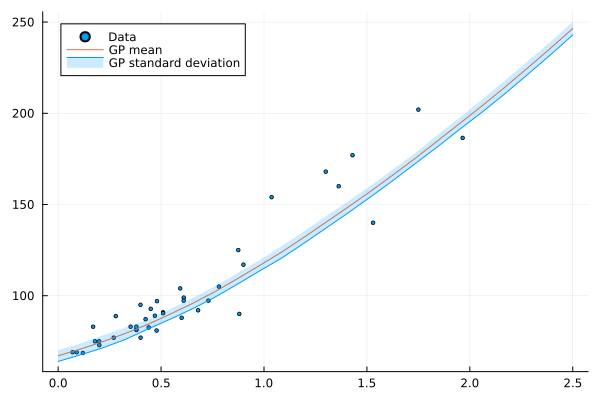

In [33]:
plot(z_obs[1:40], observations[1:40], label="Data", ms=2, seriestype=:scatter)
#plot!(zlat, H1)
plot!(zlat, vec(gp_m1), label="GP mean")
plot!(zlat, vec(gp_m1 .- gp_s1),  fillrange = vec(gp_m1 .+ gp_s1), fillalpha=0.2, c=1, label="GP standard deviation")

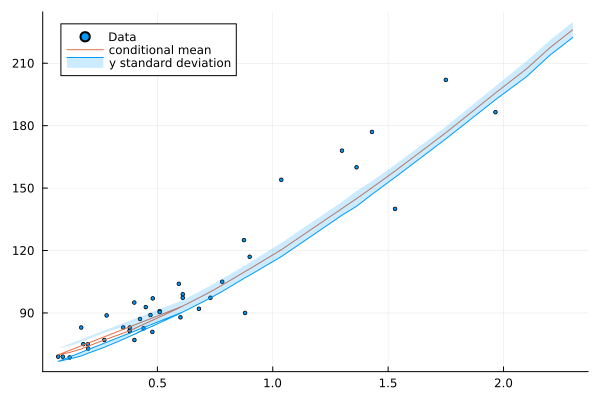

In [34]:
# observed grid
plot(z_obs[1:40], observations[1:40], label="Data", ms=2, seriestype=:scatter)
#plot!(zlat, H1)
plot!(z_obs, vec(y_m1), label="conditional mean")
plot!(z_obs, vec(y_m1 .- y_s1),  fillrange = vec(y_m1 .+ y_s1), fillalpha=0.2, c=1, label="y standard deviation")

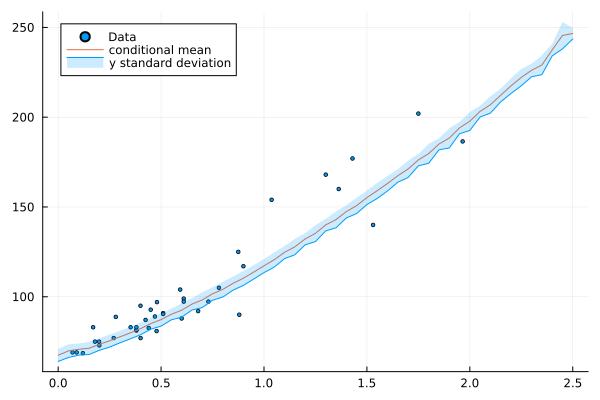

In [35]:
# integrated grid
plot(z_obs[1:40], observations[1:40], label="Data", ms=2, seriestype=:scatter)
#plot!(zlat, H1)
plot!(z_integ, vec(y_m2), label="conditional mean")
plot!(z_integ, vec(y_m2 .- y_s2),  fillrange = vec(y_m2 .+ y_s2), fillalpha=0.2, c=1, label="y standard deviation")

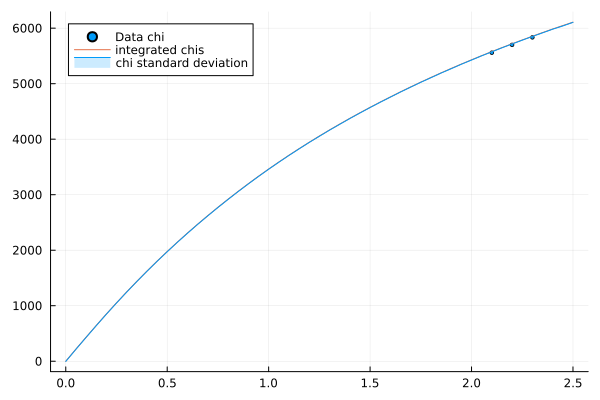

In [36]:
plot(z_obs[41:43], observations[41:43], label="Data chi", ms=2, seriestype=:scatter)
#chicont = comoving_radial_distance(cosmo1, zlat)
#plot!(zlat, chicont)
chivector = chiitp(z_integ)
plot!(z_integ, chiitp(z_integ), label="integrated chis")
plot!(z_integ, (chivector-vec(y_s2)),  fillrange = (chivector+vec(y_s2)), fillalpha=0.2, c=1, label="chi standard deviation")

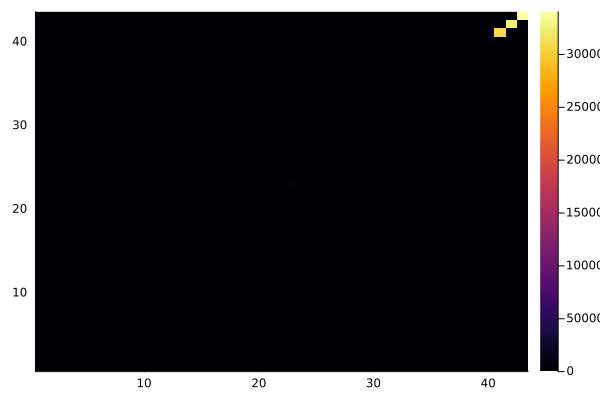

In [37]:
plot(heatmap(covariance_obs))

In [38]:
sigma = diag(covariance_obs)

43-element Vector{Float64}:
    500.049
    702.299
   1017.18
    384.1600000000001
    144.0
    686.4399999999999
     64.0
     16.0
     25.0
    876.1600000000001
      ⋮
    289.0
   1128.96
    324.0
    196.0
   1600.0
   2540.16
 308936.6470056406
 324798.81463341723
 340352.99139770214

### 3. Define our statistical model

In [45]:
@model function stats_model(y; int_grid=z_integ, X=zlat, data_x=z_obs, data_cov=covariance_obs)
    # Priors.
    eta2 ~ 200*Uniform(0.0, 0.1)
    l2 ~ 0.02*Uniform(0.1, 3)
    v2 ~ MvNormal(zeros(length(X)), ones(length(X)))
    kernel = sqexp_cov_fn(X, eta=eta2, l=l2)
    cpar = CosmoPar(Ωm=omegam,  Ωb=omegab, h=hc)
    mean_hz = cpar.h*100*Ez(cpar, X)
    h_gp = latent_GP(mean_hz, v2, kernel)

    H_int = conditional(X, int_grid, h_gp, sqexp_cov_fn; eta=eta2, l=l2)
    H_int_grid = linear_interpolation(int_grid, H_int)
    chi_interp = comoving_d(int_grid, H_int_grid)

    hdata := H_int_grid(data_x[1:40])
    chidata := chi_interp(data_x[41:43])
    datay = [hdata;chidata]

    y = MvNormal(datay, data_cov)

end

stats_model (generic function with 2 methods)

### 4. Sample the model

In [46]:
chain = sample(stats_model(observations), NUTS(20, 0.65), 100)

Sampling   0%|                                          |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 1.6
└ @ Turing.Inference /Users/vis/.julia/packages/Turing/QN7BL/src/mcmc/hmc.jl:212
Sampling   1%|▍                                         |  ETA: 0:04:05
Sampling   2%|▊                                         |  ETA: 0:02:05
Sampling   2%|█                                         |  ETA: 0:01:24
Sampling   3%|█▍                                        |  ETA: 0:01:13
Sampling   4%|█▊                                        |  ETA: 0:01:02
Sampling   5%|██▏                                       |  ETA: 0:00:52
Sampling   6%|██▌                                       |  ETA: 0:00:45
Sampling   7%|██▊                                       |  ETA: 0:00:40
Sampling   8%|███▏                                      |  ETA: 0:00:36
Sampling   8%|███▌                                      |  ETA: 0:00:34
Sampling   9%|███▉                                      |  ETA: 0:00:31
Sampling  10%|█

Chains MCMC chain (100×81×1 Array{Float64, 3}):

Iterations        = 21:1:120
Number of chains  = 1
Samples per chain = 100
Wall duration     = 30.49 seconds
Compute duration  = 30.49 seconds
parameters        = eta2, l2, v2[1], v2[2], v2[3], v2[4], v2[5], v2[6], v2[7], v2[8], v2[9], v2[10], v2[11], v2[12], v2[13], v2[14], v2[15], v2[16], v2[17], v2[18], v2[19], v2[20], v2[21], v2[22], v2[23], v2[24], hdata[1], hdata[2], hdata[3], hdata[4], hdata[5], hdata[6], hdata[7], hdata[8], hdata[9], hdata[10], hdata[11], hdata[12], hdata[13], hdata[14], hdata[15], hdata[16], hdata[17], hdata[18], hdata[19], hdata[20], hdata[21], hdata[22], hdata[23], hdata[24], hdata[25], hdata[26], hdata[27], hdata[28], hdata[29], hdata[30], hdata[31], hdata[32], hdata[33], hdata[34], hdata[35], hdata[36], hdata[37], hdata[38], hdata[39], hdata[40], chidata[1], chidata[2], chidata[3]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamil

In [49]:
hdata_p = group(chain, :hdata).value.data[:,:,1]

100×40 Matrix{Float64}:
 82.0533  87.8275   94.1995  77.4229  …  145.653  152.298  168.691  189.949
 75.7494  84.4127   90.7233  68.0634     149.505  153.771  175.687  194.351
 85.8676  93.596    98.429   69.2943     149.882  157.524  177.93   197.731
 85.8676  93.596    98.429   69.2943     149.882  157.524  177.93   197.731
 74.2773  81.577    88.3185  67.1735     149.052  158.079  174.272  191.224
 80.6499  87.6706   93.64    67.8507  …  148.206  155.595  173.515  194.533
 85.4769  90.1466   93.8339  74.8499     145.93   155.216  177.283  196.674
 85.1525  90.0856   94.0216  72.0419     149.672  157.46   175.485  196.35
 85.1525  90.0856   94.0216  72.0419     149.672  157.46   175.485  196.35
 85.4374  92.8685  100.229   72.7099     151.009  161.292  178.272  195.327
  ⋮                                   ⋱                             
 79.239   89.0073   94.8023  62.926      145.017  152.925  176.856  195.077
 81.2088  87.5809   94.5984  76.4114     154.078  159.082  171.873  197.9

### 5. Check how our posteriors look like

In [42]:
eta_p = group(chain, :eta2).value.data[:, :, 1];
l_p = group(chain, :l2).value.data[:, :, 1];
v_p = group(chain, :v2).value.data[:, :, 1];

In [43]:
println(length(v_p))

2400


In [44]:
N_samples2 = length(eta_p)
gps3=zeros(N_samples2, 24)
ys3=zeros(N_samples2, length(z_integ))
for i in 1:N_samples2
    gps3[i, :], ys3[i, :] = model_latent_GP(eta_p[i], l_p[i], v_p[i, :];
                                                data_x=z_integ)
end

y_m3, y_s3 = mean(ys3, dims=1), std(ys3, dims=1);
gp_m3, gp_s3 = mean(gps3, dims=1), std(gps3, dims=1);

MethodError: MethodError: no method matching model_latent_GP(::Float64, ::Float64, ::Vector{Float64}; data_x::Vector{Float64})
This error has been manually thrown, explicitly, so the method may exist but be intentionally marked as unimplemented.

Closest candidates are:
  model_latent_GP(::Any, ::Any, ::Any; x, z, data_cov) got unsupported keyword argument "data_x"
   @ Main ~/Desktop/Cosmography_GP/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sZmlsZQ==.jl:1


In [51]:
hpmean, hps = mean(hdata_p, dims=1), std(hdata_p, dims=1)

([81.33802084958252 88.10392920786728 … 175.873640050983 195.65450018015233], [3.388314192190624 3.5932863079001236 … 2.969611755032289 2.635427681528996])

In [ ]:
plot(z_obs, observations, label="Data", ms=2, seriestype=:scatter)
#plot!(zc, H1, label="LCDM", lc=:black)
plot!(LinRange(0, 2.3, 100), vec(y_m3), label="Y mean")
plot!(LinRange(0, 2.3, 100), vec(y_m3 .- y_s3),  fillrange = vec(y_m3 .+ y_s3), fillalpha=0.2, c=1, label="Y standard deviation")


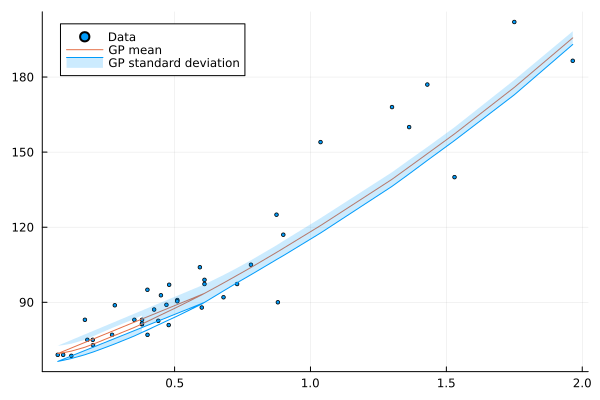

In [61]:
plot(z_obs[1:40], observations[1:40], label="Data", ms=2, seriestype=:scatter)
#plot!(zcont, H1, label="LCDM", lc=:black)
plot!(z_obs[1:40], vec(hpmean), label="GP mean")
plot!(z_obs[1:40], vec(hpmean .- hps),  fillrange = vec(hpmean .+ hps), fillalpha=0.2, c=1, label="GP standard deviation")

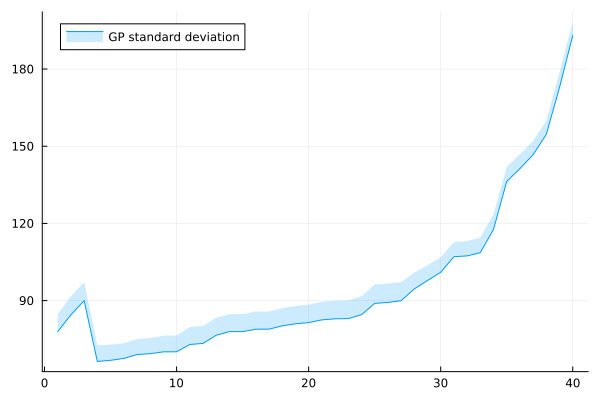

In [58]:

plot(vec(hpmean .- hps),  fillrange = vec(hpmean .+ hps), fillalpha=0.2, c=1, label="GP standard deviation")